This notebook is for creating better figures using up to date data 

In [2]:
#import libraries
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr

In [8]:
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'q':'_qnet.nc', 'SST': '_tos.nc','T50':'_t50.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass


[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_qnet.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_t50.nc'


In [9]:
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/REAN_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'q':'_qnet.nc', 'SST': '_tos.nc', 'T50':'_t50.nc'}
OBS={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    mod={}
    for key in varis.keys():
        #input file
        inp_files = (os.path.join(datadir, model, str(model+varis[key])))
        try:
            #for NOAA data mask landvalues
            if model == 'NOAA_oiSST':
                var = xr.open_dataset(inp_files).sst
                LSM_path = (os.path.join(datadir, model, 'LSM.nc'))
                LSM = xr.open_dataarray(LSM_path)
                var = var.where(LSM[0])
            else:
                var = xr.open_dataarray(inp_files)

            #put into dict
            mod[key]=var
            OBS[model] = mod

        except Exception as e:
            print(e)
            pass
#calculate the DTDT and  cliamtology of NOAA
NSST = OBS['NOAA_oiSST']['SST']
Ndt = NSST.differentiate(coord = 'time', edge_order=1,  datetime_unit= 's')
NSST = NSST.groupby('time.month').mean('time')
Ndt = Ndt.groupby('time.month').mean('time')
#now repack into dictionary
OBS['NOAA_oiSST']['SST'] = NSST
OBS['NOAA_oiSST']['dTdt'] = Ndt

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/GODAS/GODAS_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/SODA3.4.2/SODA3.4.2_t50.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/d

KeyError: 'NOAA_oiSST'

In [10]:
#calculate residual, reverse sign on advection
models1={}
for model in models.keys():
    try:
        HB=models[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid, 'SST':SST}
        models1[model]=HB1
    except Exception as e:
        print(e, model)
OBS1={}
varis = ['dTdt', 'ua', 'va', 'wa', 'q', 'SST']
for model in OBS.keys():
    HB=OBS[model]
    #now calc resid and change signs of advection terms
    try:
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid, 'SST':SST}
        #OBS1[model]=HB1
    except Exception as e:
        print(e, model)
    #repack all varis into new dictname
    for key in varis:
        try:
            vari = HB[key]
            HB1 = {key: vari}
        except Exception as e:
            print(e, model)
    OBS1[model]=HB1


'dTdt' OAFLUX
'dTdt' OAFLUX
'ua' OAFLUX
'va' OAFLUX
'wa' OAFLUX
'SST' OAFLUX
'dTdt' ERA5
'dTdt' ERA5
'ua' ERA5
'va' ERA5
'wa' ERA5
'SST' ERA5
'ua' ARGO
'ua' ARGO
'va' ARGO
'wa' ARGO
'q' ARGO


In [32]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [40]:
def get_model_TS(MM_D):
    varis = ['dTdt', 'ua', 'va', 'wa', 'q', 'SST']
    DSD={}
    for i, model in enumerate(MM_D.keys()):
        HB = MM_D[model]
        for key in varis:
            try:
                vari = HB[key]
                vari = vari.assign_coords({'model':model})
                if i == 0:
                    varim = vari
                else:
                    varim = xr.concat([varim, vari], dim = 'model')
                #now pack into dictionary
                DSD[key] = vari
            except Exception as e:
                print(e, key, model)
    return DSD
    #now we unpack the dict DSD to get the 'modelseries' we want
    #TM=DSD['dTdt']
    #UM=DSD['ua']
    #M=DSD['va']
    #WM=DSD['wa']
    #QQ=DSD['q']
    #RM = DSD['res']
    #SM = DSD['SST']
    #return TM, UM, VM, WM, QM, RM, SM               



In [35]:
#fucntion to create regional plots for multimodel mean of each variable with SST
def plot_region_MM(MM_D, OBS_D, lat, lat_r, lon, lon_r):
    #create a 'model-series' for each variable
    TM, UM, VM, WM, QM, RM, SM = get_model_TS(MM_D)
    TO, UO, VO, WO, QO, RO, SO = get_model_TS(OBS_D)

    #Now calculate the multimodel means/
    TMM = TM.median(dim = 'model')
    UMM = UM.median(dim = 'model')
    VMM = VM.median(dim = 'model')
    WMM = WM.median(dim = 'model')
    QMM = QM.median(dim = 'model')
    RMM = RM.median(dim = 'model')
    SMM = SM.median(dim = 'model')
    #get the spatial average of these
    #TM = get_region(TM, lat, lat_r, lon, lon_r)
    #NOW LETS PLOT
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 8),  sharex='all')
    fig.set_facecolor('white')
    axes[0,0].plot(range(1,13), get_region((SMM), lat, lat_r, lon, lon_r), linestyle='-', marker='o',  label = 'CMIP6 Multimodel Median')

    axes[0,1].plot(range(1,13), get_region((TMM*(3986*1026*50)), lat, lat_r, lon, lon_r), linestyle='-', marker='o', label = 'CMIP6 Multimodel Median')
    axes[0,2].plot(range(1,13), get_region((QMM*(3986*1026*50)), lat, lat_r, lon, lon_r), linestyle='-', marker='o', label = 'Qnet')
    axes[1,0].plot(range(1,13), get_region((UMM)*(3986*1026*50), lat, lat_r, lon, lon_r), linestyle='-', marker='o',label = '-U Advection')
    axes[1,1].plot(range(1,13), get_region((VMM)*(3986*1026*50), lat, lat_r, lon, lon_r),  linestyle='-', marker='o',label = '-V Advection')
    axes[1,2].plot(range(1,13), get_region((WMM)*(3986*1026*50), lat, lat_r, lon, lon_r),  linestyle='-', marker='o',label = '-W Advection')
    axes[1,3].plot(range(1,13), get_region((RMM)*(3986*1026*50), lat, lat_r, lon, lon_r), linestyle='-', marker='o',label = 'CMIP6 Multimodel Median')

    
    return fig

In [36]:
plot_region_MM(models1, OBS1, 50,70, 10, -10)

KeyError: 'dTdt'

In [42]:
TO = get_model_TS(OBS1)


'dTdt' dTdt OAFLUX
'ua' ua OAFLUX
'va' va OAFLUX
'wa' wa OAFLUX
'SST' SST OAFLUX
'dTdt' dTdt ERA5
'ua' ua ERA5
'va' va ERA5
'wa' wa ERA5
'SST' SST ERA5
'dTdt' dTdt ARGO
'ua' ua ARGO
'va' va ARGO
'wa' wa ARGO
'q' q ARGO
'dTdt' dTdt NOAA_oiSST
'ua' ua NOAA_oiSST
'va' va NOAA_oiSST
'wa' wa NOAA_oiSST
'q' q NOAA_oiSST


In [51]:
OBS1['NOAA_oiSST']

{'SST': <xarray.DataArray 'sst' (month: 12, lat: 180, lon: 360)>
 array([[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [-1.7900007, -1.7897568, -1.7897568, ..., -1.7900007,
          -1.7900007, -1.7900007],
         [-1.7900007, -1.7900007, -1.7900007, ..., -1.7900007,
          -1.7900007, -1.7900007],
         [-1.7900007, -1.7900007, -1.7900007, ..., -1.7900007,
          -1.7900007, -1.7900007]],
 
        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
 ...
         [-1.7895006, -1.789750

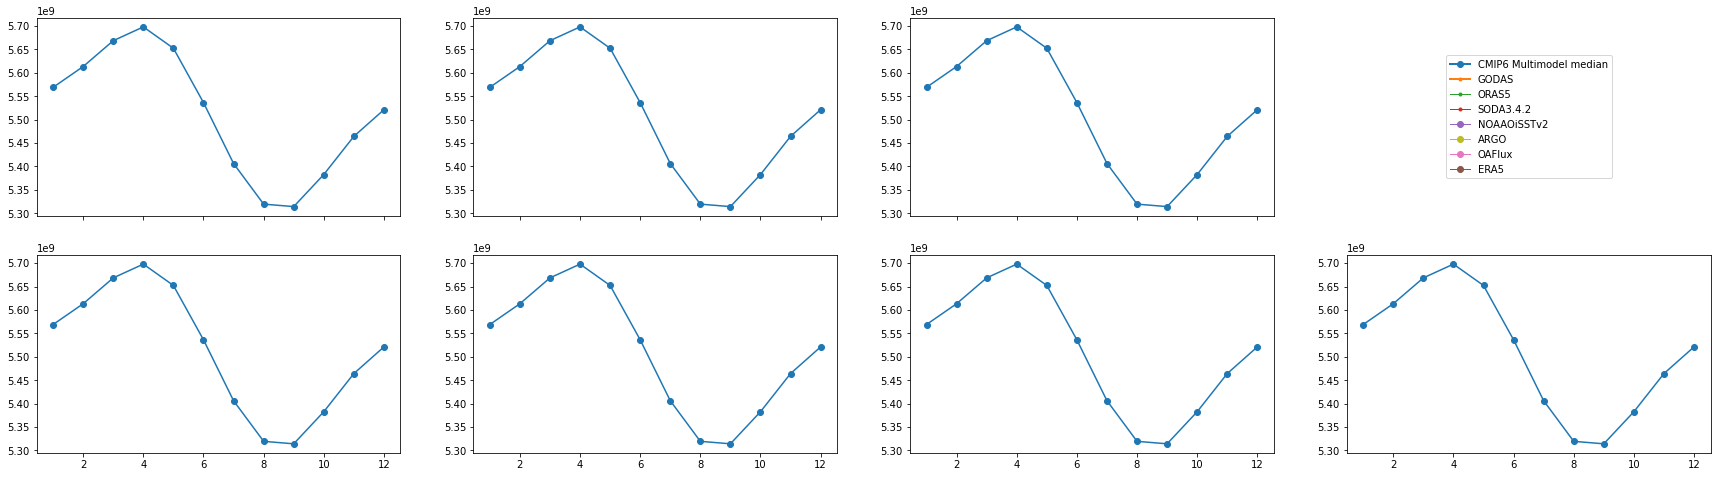

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 8),  sharex='all')
fig.set_facecolor('white')
lat=50
lat_r = 70
lon = -10
lon_r = 10
g=axes[0,0].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']), linestyle='-', marker='o',  label = 'CMIP6 Multimodel Median')

a=axes[0,1].plot(range(1,13),(models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']), linestyle='-', marker='o', label = 'CMIP6 Multimodel Median')
b=axes[0,2].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']), linestyle='-', marker='o', label = 'Qnet')
c=axes[1,0].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']), linestyle='-', marker='o',label = '-U Advection')
d=axes[1,1].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']),  linestyle='-', marker='o',label = '-V Advection')
e=axes[1,2].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']),  linestyle='-', marker='o',label = '-W Advection')
f=axes[1,3].plot(range(1,13), (models1['ACCESS-CM2']['SST']*(3986*1026*50)).mean(['lat', 'lon']), linestyle='-', marker='o',label = 'CMIP6 Multimodel Median')
axes[0,3].set_axis_off()

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=2, marker='o'),
                Line2D([0], [0], color='tab:orange', lw=2, marker='.'),
                Line2D([0], [0], color='tab:green', lw=1, marker='.'),
                Line2D([0], [0], color='tab:red', lw=1, marker='.'),
                Line2D([0], [0], color='tab:purple', lw=1, marker='o'),
                Line2D([0], [0], color='tab:olive', lw=1, marker='o'),
                Line2D([0], [0], color='tab:pink', lw=1, marker='o'),
                Line2D([0], [0], color='tab:brown', lw=1, marker='o')]

custom_labels = ['CMIP6 Multimodel median', 'GODAS', 'ORAS5', 'SODA3.4.2', 'NOAAOiSSTv2', 'ARGO',
                 'OAFlux', 'ERA5']
axes[0,3].legend(custom_lines, custom_labels, loc = 'center')

#axes[0,3].legend(handles)
#legend([a,b,c,d,e,f])

In [56]:
get_region((models1['ACCESS-CM2']['SST']*(3986*1026*50)), lat, lat_r, lon, lon_r)

<xarray.DataArray 'tos' (month: 12)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [58]:
models1['ACCESS-CM2']['SST']

<xarray.DataArray 'tos' (month: 12, lat: 60, lon: 95)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 17.552269, 18.641138],
        [      nan,       nan, ..., 15.830636, 15.393892]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 16.155424, 17.48786 ],
        [      nan,       nan, ..., 14.073252, 13.626736]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 21.665703, 21.453081],
        [      nan,       nan, ..., 20.897768, 20.398783]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 19.60295 , 19.972794],
        [      nan,       nan, ..., 18.417376, 17.953798]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [14]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [13]:
#Lets look at ARGO T50 and SST
ARGO50 = OBS['ARGO']['T50']
ARGOS = OBS['ARGO']['SST']
M50
MS

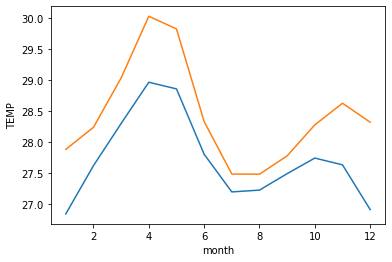

In [17]:
plt.figure()
get_region(ARGO50, -10, 10, 50, 70).plot()
get_region(ARGOS, -10, 10, 50, 70).plot()

In [23]:
DSD={}
varis=['T50', 'SST']
for i, model in enumerate(models.keys()):
    HB = models[model]
    try:
        SST = HB['SST']
        T50 = HB['T50']
        SST = SST.assign_coords({'model':model})
        T50 = T50.assign_coords({'model':model})
        if i == 0:
            T50m = T50
            SSTm = SST
        else:
            T50m = xr.concat([T50m, T50], dim = 'model')
            SSTm = xr.concat([SSTm, vari], dim = 'model')
        #now pack into dictionary
        DSD[key] = vari
    except Exception as e:
        print(e, key, model)

Text(0.5, 1.0, 'WTIO SST vs T50')

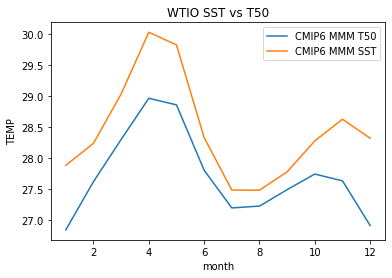

In [36]:
plt.figure()
get_region(ARGO50, -10, 10, 50, 70).plot(label = 'CMIP6 MMM T50')
get_region(ARGOS, -10, 10, 50, 70).plot(label = 'CMIP6 MMM SST')
plt.legend()
plt.title('WTIO SST vs T50')

Text(0.5, 1.0, 'WTIO SST vs T50')

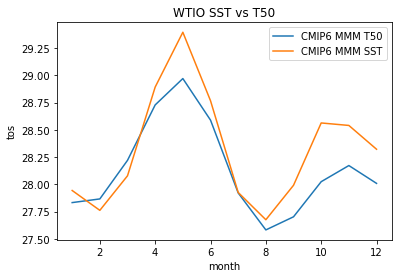

In [33]:
plt.figure()
get_region(T50m.median('model'), -10, 10, 50, 70).plot(label = 'CMIP6 MMM T50')
get_region(SSTm.median('model'), -10, 10, 50, 70).plot(label = 'CMIP6 MMM SST')
plt.legend()
plt.title('WTIO SST vs T50')